In [1]:
# !pip install langchain
# !pip install langchain_core
# !pip install langchain_ollama
# !pip install langchain_huggingface
# !pip install prompt

In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama

In [ ]:
# import getpass
# import os

# def _set_if_undefined(var: str) -> None:
#     if os.environ.get(var):
#         return
#     os.environ[var] = getpass.getpass(var)


# _set_if_undefined("TAVILY_API_KEY")
# # _set_if_undefined("FIREWORKS_API_KEY")

### 設定 `llm`

In [4]:
!ollama list

NAME                   ID              SIZE      MODIFIED     
llava:34b              3d2d24f46674    20 GB     7 days ago      
minicpm-v:latest       c92bfad01205    5.5 GB    7 days ago      
deepseek-r1:32b        38056bbcbb2d    19 GB     8 days ago      
gemma3:27b             30ddded7fba6    17 GB     8 days ago      
llama3.2-vision:90b    d2a5e64c56a9    54 GB     9 days ago      
qwq:latest             cc1091b0e276    19 GB     11 days ago     
deepseek-r1:70b        0c1615a8ca32    42 GB     11 days ago     
llama3.3:latest        a6eb4748fd29    42 GB     2 months ago    


In [5]:
llm = ChatOllama(
    model="llama3.3:latest",
    temperature=0,
    # other params...
)

### 設定 `embeddings` 與 `vector_store`

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### 建立資料來源 `doc`

In [8]:
import requests
response = requests.get("https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l")
print(response.status_code)
print(response.text[:100])  # 只顯示部分內容確認是否成功抓取


200
<!DOCTYPE html>
<html lang="dev" data-themeable="true">

<head>
    <meta charset="utf-8">
    <meta


In [9]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(id="publish-page")
loader = WebBaseLoader(
    web_paths=("https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 2941


In [10]:
print(docs[0].page_content[:100])

# 詐騙判斷準則


## 詐騙準則種類一:賭博、博弈
### 關鍵字:娛樂城、百家樂、運彩
**娛樂城**
- 非詐騙類型(label = 0)：
1. 要求推薦平台或代理，沒有誘導之意的貼文。
2


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters)
    chunk_overlap=100,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 8 sub-documents.


In [12]:
print(f"原始文章拆分為 {len(all_splits)} 個子文件。")

for i in range(len(all_splits)):
    print(f"\n第{i+1}個子文件預覽:\n{all_splits[i].page_content}")

原始文章拆分為 8 個子文件。

第1個子文件預覽:
# 詐騙判斷準則


## 詐騙準則種類一:賭博、博弈
### 關鍵字:娛樂城、百家樂、運彩
**娛樂城**
- 非詐騙類型(label = 0)：
1. 要求推薦平台或代理，沒有誘導之意的貼文。
2. 抱怨、咒罵娛樂城、百家樂之詐騙詐欺行為的貼文。
3. 分享戰積、知識或自己對於娛樂城百家樂之想法的貼文。
4. 單純詢問有關娛樂城與百家樂的問題，無誘導他人傾向之貼文。
- 詐騙類型(label = 1):
1. 推薦他人平台或代理，並給予不合理之條件，像是免費給錢、註冊金等，判定為詐騙。
2. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。

**百家樂**
基本和上述條件差不多，只是多了專有名詞：救紅，指的是玩家虧錢，找人來代理操作，試圖少虧或盈利。
- 非詐騙類型(label = 0):
1. 單純尋找救紅，可能會提到一些條件，但無欺騙他人之意的貼文
- 詐騙類型(label = 1):
1. 推薦救紅的代理，或自薦，並給予不合理之保證或條件，判定為詐騙。

第2個子文件預覽:
**運彩**
- 非詐騙類型(label = 0):
1. 單純分享運彩賺錢、虧錢、知識，無誘導之意圖的貼文。
2. 單純的運彩分析，無誘導他人加入群組或入金之意圖的貼文。
3. 單純詢問問題，無誘導他人之傾向的貼文。
- 詐騙類型(label = 1):
1. 意圖誘導他人加入群組，或像老師求教的貼文。
2. 過高且不合理的運彩勝率，並有誘使他人入金或加入群組的貼文。
3. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。

第3個子文件預覽:
## 詐騙準則種類二:投資
### 關鍵字:投資、股票、加密貨幣
**投資**
- 非詐騙類型(label = 0):
1. 單純分享投資消息或投資知識的貼文，例如個股投資進場退場、加密貨幣投資進場退場。
2. 單純分享自己投資賺賠的貼文，無誘導加入群組、追蹤IG(不一定)或投資之意圖。
3. 詢問問題，無誘導的意圖之貼文。
- 詐騙類型(label = 1):
1. 有誘導他人進場之意圖的貼文，例如:明天台積電一定跌，趕快進場、**內部消息**...
2. 用不合理或誇大(穩賺不賠、零風險)等字眼誘導他人跟隨進場、加入群組、追蹤IG的貼文。
3. 推薦或自薦老師，誇大獲利以誘使他人跟隨

In [13]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['a8ae346b-ee4e-45e3-93df-839f9fa0e926', '20fe8377-3201-4d96-afcc-2afd66eced49', '15718d58-f69e-4898-bd76-32f15e8a5c87']


### 選則問答模型

1. **BERT (Bidirectional Encoder Representations from Transformers)**  
   - `bert-base-uncased`：適用於各種問答任務，基於大規模語料訓練，無區分大小寫。
   - `bert-large-uncased`：比 `bert-base` 更大，精度更高，但運行速度較慢。
   - `bert-base-cased`：適用於區分大小寫的語言處理任務。
   
2. **DistilBERT (BERT 的輕量化版)**  
   - `distilbert-base-cased`：BERT 的壓縮版，速度更快，內存使用更少，適合需要高效運行的場景。
   - `distilbert-base-uncased`：無區分大小寫的輕量版，運行更快。

3. **RoBERTa (Robustly Optimized BERT Approach)**  
   - `roberta-base`：BERT 的變體，經過更多訓練數據的調整，通常能提供更好的表現。
   - `roberta-large`：更大的 RoBERTa 模型，適合高精度需求。

4. **ALBERT (A Lite BERT)**  
   - `albert-base-v2`：ALBERT 是一種比 BERT 更小巧、更高效的模型，尤其適合資源有限的情況。

5. **T5 (Text-to-Text Transfer Transformer)**  
   - `t5-small`：小型版本，適合快速試驗。
   - `t5-base`：中等版本，適用於大多數任務。
   - `t5-large`：較大版本，精度更高。

6. **BART (Bidirectional and Auto-Regressive Transformers)**  
   - `facebook/bart-large`：Facebook 開發的 BART 模型，適用於問答、文本生成等任務，表現非常好。
   - `facebook/bart-large-cnn`：經過針對抽取式總結訓練的 BART 模型，也適用於問答。

7. **XLNet**  
   - `xlnet-base-cased`：XLNet 是一個基於 Transformer 的語言模型，能夠處理更長的上下文信息。

8. **ELECTRA**  
   - `google/electra-base-discriminator`：ELECTRA 模型與 BERT 類似，但它的預訓練方法有所不同，通常在較小的數據集上表現更好。

9. **T5 和 BART 的其他變體**  
   - `google/t5-v1_1-base`：T5 模型的一個變體，適用於問答和生成任務。
   - `facebook/bart-large-mnli`：針對自然語言推理（NLI）訓練的 BART 版本，但也可用於問答。

10. **Longformer**  
   - `allenai/longformer-base-4096`：Longformer 是一種設計來處理長文本的模型，適用於大規模文檔的問答和摘要。

11. **DistilBERT for SQuAD**  
   - `distilbert-base-cased-distilled-squad`：DistilBERT 的 SQuAD 微調版，專為問答任務設計，對於 SQuAD 等數據集具有優異的表現。


In [55]:
from transformers import pipeline
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
print(f"Model max length: {tokenizer.model_max_length}")

# 指定模型
qa_pipeline = pipeline(
    "question-answering",
    model="allenai/longformer-base-4096",
    tokenizer="allenai/longformer-base-4096",
    max_length=tokenizer.model_max_length,  # 設置為模型支持的最大長度
    doc_stride=128,   # 合理設置 stride
    truncation=True   # 啟用截斷以避免超出限制
)


context = "人工智慧（AI）是計算機科學的一個領域，旨在創造能夠執行需要人類智慧的任務的機器。"
question = "什麼是人工智慧？"

answer = qa_pipeline(question=question, context=context)
print(answer['answer'])

Model max length: 1000000000000000019884624838656


Some weights of LongformerForQuestionAnswering were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


旨在創造能夠執行需要人類智慧的任務的機器


### RAG 方法一:

`retrieve` + `generate`

In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# retrieve 部分保持不變，假設 vector_store 已定義
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    result = qa_pipeline(question=state["question"], context=docs_content)
    return {"answer": result['answer']}

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

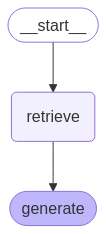

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
result = graph.invoke({"question": "如何判斷娛樂城詐騙?請提供中文關鍵字"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='a8ae346b-ee4e-45e3-93df-839f9fa0e926', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 0}, page_content='# 詐騙判斷準則\n\n\n## 詐騙準則種類一:賭博、博弈\n### 關鍵字:娛樂城、百家樂、運彩\n**娛樂城**\n- 非詐騙類型(label = 0)：\n1. 要求推薦平台或代理，沒有誘導之意的貼文。\n2. 抱怨、咒罵娛樂城、百家樂之詐騙詐欺行為的貼文。\n3. 分享戰積、知識或自己對於娛樂城百家樂之想法的貼文。\n4. 單純詢問有關娛樂城與百家樂的問題，無誘導他人傾向之貼文。\n- 詐騙類型(label = 1):\n1. 推薦他人平台或代理，並給予不合理之條件，像是免費給錢、註冊金等，判定為詐騙。\n2. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。\n\n**百家樂**\n基本和上述條件差不多，只是多了專有名詞：救紅，指的是玩家虧錢，找人來代理操作，試圖少虧或盈利。\n- 非詐騙類型(label = 0):\n1. 單純尋找救紅，可能會提到一些條件，但無欺騙他人之意的貼文\n- 詐騙類型(label = 1):\n1. 推薦救紅的代理，或自薦，並給予不合理之保證或條件，判定為詐騙。'), Document(id='1d7b8de6-d166-425b-811b-7152393ad409', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 1153}, page_content='**加密貨幣**\n大致可用上面投資的邏輯\n- 非詐騙類型(label = 0):\n1. 反串偏多，小心判斷，傳一個搞笑的(開始做加密貨幣到現在五年\\n房子越換越大\\n原本都睡10幾坪的小公寓\\n現在我家應該有幾千坪了\\n就是知名地標大建案\\n在台北很有名的\\n真舒服\\n有興趣的可以來我家\\nGoogle找大安森林公園")\n- 詐騙類型(label = 1):\n1. 贈送金錢為理

In [19]:
for step in graph.stream(
    {"question": "如何判斷娛樂城詐騙?請提供中文關鍵字"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='a8ae346b-ee4e-45e3-93df-839f9fa0e926', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 0}, page_content='# 詐騙判斷準則\n\n\n## 詐騙準則種類一:賭博、博弈\n### 關鍵字:娛樂城、百家樂、運彩\n**娛樂城**\n- 非詐騙類型(label = 0)：\n1. 要求推薦平台或代理，沒有誘導之意的貼文。\n2. 抱怨、咒罵娛樂城、百家樂之詐騙詐欺行為的貼文。\n3. 分享戰積、知識或自己對於娛樂城百家樂之想法的貼文。\n4. 單純詢問有關娛樂城與百家樂的問題，無誘導他人傾向之貼文。\n- 詐騙類型(label = 1):\n1. 推薦他人平台或代理，並給予不合理之條件，像是免費給錢、註冊金等，判定為詐騙。\n2. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。\n\n**百家樂**\n基本和上述條件差不多，只是多了專有名詞：救紅，指的是玩家虧錢，找人來代理操作，試圖少虧或盈利。\n- 非詐騙類型(label = 0):\n1. 單純尋找救紅，可能會提到一些條件，但無欺騙他人之意的貼文\n- 詐騙類型(label = 1):\n1. 推薦救紅的代理，或自薦，並給予不合理之保證或條件，判定為詐騙。'), Document(id='1d7b8de6-d166-425b-811b-7152393ad409', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 1153}, page_content='**加密貨幣**\n大致可用上面投資的邏輯\n- 非詐騙類型(label = 0):\n1. 反串偏多，小心判斷，傳一個搞笑的(開始做加密貨幣到現在五年\\n房子越換越大\\n原本都睡10幾坪的小公寓\\n現在我家應該有幾千坪了\\n就是知名地標大建案\\n在台北很有名的\\n真舒服\\n有興趣的可以來我家\\nGoogle找大安森林公園")\n- 詐騙類型(label 

In [20]:
for message, metadata in graph.stream(
    {"question": "如何判斷娛樂城詐騙?"}, stream_mode="messages"
):
    print(message.content, end="|")

### RAG 方法二: 
`retrieve` + `analyze_query` + `generate`

In [21]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l',
 'start_index': 0,
 'section': 'beginning'}

In [22]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [23]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [ ]:
import re

class State(TypedDict):
    question: str
    # highlight-next-line
    query: Search
    context: List[Document]
    answer: str


# highlight-next-line
def analyze_query(state: State):
    # highlight-next-line
    structured_llm = llm.with_structured_output(Search)
    # highlight-next-line
    query = structured_llm.invoke(state["question"])
    # highlight-next-line
    return {"query": query}


def retrieve(state: State):
    # highlight-start
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(query["query"])
    # highlight-end
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = qa_pipeline(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"answer": response.content}


# highlight-start
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
# highlight-end
graph = graph_builder.compile()

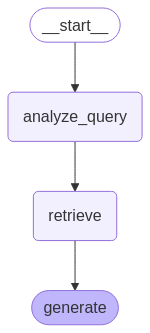

In [68]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [69]:
import json

category = 'investment'
with open(f"../Datasets_crawler/data_{category}.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)

In [70]:
# 假設這是你從 dataset 中取出的貼文內容
post = dataset[0]['text']
question = f"貼文內容:\n{post}，請判斷該貼文是否為詐騙，並輸出 label = ?"

In [71]:
for step in graph.stream(
    {"question": question},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

Model max length: 1000000000000000019884624838656


Some weights of LongformerForQuestionAnswering were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


{'analyze_query': {'query': {'query': '资料內容 別作 議姐 股票', 'section': 'scam detection'}}}

----------------

{'retrieve': {'context': [Document(id='8515c141-1ea4-453f-8706-c0508ab306e4', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 656, 'section': 'middle'}, page_content='## 詐騙準則種類二:投資\n### 關鍵字:投資、股票、加密貨幣\n**投資**\n- 非詐騙類型(label = 0):\n1. 單純分享投資消息或投資知識的貼文，例如個股投資進場退場、加密貨幣投資進場退場。\n2. 單純分享自己投資賺賠的貼文，無誘導加入群組、追蹤IG(不一定)或投資之意圖。\n3. 詢問問題，無誘導的意圖之貼文。\n- 詐騙類型(label = 1):\n1. 有誘導他人進場之意圖的貼文，例如:明天台積電一定跌，趕快進場、**內部消息**...\n2. 用不合理或誇大(穩賺不賠、零風險)等字眼誘導他人跟隨進場、加入群組、追蹤IG的貼文。\n3. 推薦或自薦老師，誇大獲利以誘使他人跟隨的貼文。\n\n**股票**\n大致可用上面投資的邏輯\n- 非詐騙類型(label = 0):\n1. 單純推薦個股，無誘導之意圖的貼文，追蹤IG不是一定是詐騙，要判斷一下。\n- 詐騙類型(label = 1):\n1. 過大的獲利金額，可能也是誘導進場的訊息，點進去看看再判斷\n2. 模板化的貼文(看起來會像推薦個股，但格式都相差無幾，缺乏個人特色)、成立時間短的帳號\n3. 追蹤IG且IG帳號甚麼都沒有'), Document(id='ba032c46-1578-4815-84de-b28e9e93638c', metadata={'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 2561, 'section': 'end'},


thread '<unnamed>' panicked at /Users/runner/work/tokenizers/tokenizers/tokenizers/src/tokenizer/encoding.rs:319:9:
`stride` must be strictly less than `max_len=59` (note that `max_len` may be shorter than the max length of the original model, as it subtracts the number of special characters


PanicException: `stride` must be strictly less than `max_len=59` (note that `max_len` may be shorter than the max length of the original model, as it subtracts the number of special characters